**CityGML Parsing & Mapillary Integration**

Task - 1 - Extract Building Footprints

Parse the GML file and extract the geometry of each building (footprint).
Plot all building footprints together on a single plot (e.g., using matplotlib, geopandas, or shapely)

CityGML version = 1.0
LoD             = 2


In [107]:
import xml.etree.ElementTree as ET
import geopandas as gpd
import folium
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as mlpPolygon
import matplotlib
import csv

In [48]:
tree = ET.parse(".\\690_5334.gml")
root = tree.getroot()
namespace = {
    "gml": "http://www.opengis.net/gml",
    "bldg": "http://www.opengis.net/citygml/building/1.0",
    "gen": "http://www.opengis.net/citygml/generics/1.0",
    "default": "http://www.opengis.net/citygml/1.0"
}

In [ ]:
def get_building_footprints(buildings) -> list:
    building_ids = []
    footprints = []
    for building in buildings:
        building_ids.append(building.get("{http://www.opengis.net/gml}id"))
        ground_surface = building.findall(".//bldg:GroundSurface",namespaces=namespace)
        for surface in ground_surface:
            polygons = surface.findall(".//gml:Polygon",namespaces=namespace)
            for polygon in polygons:
                # Extracting the Coordinates and spliting based on whitespaces between them.
                poslist = polygon.find(".//gml:posList",namespaces=namespace).text.strip().split()
                xy_coords = [(float(poslist[i]),float(poslist[i+1])) for i in range(0,len(poslist),3)]
                z_coords = [float(poslist[i+2]) for i in range(0,len(poslist),3)]
                '''if len(set(z_coords)) ==1:
                   # All elevation levels are same inidcating a ground surface'''
                footprints.append(xy_coords)
    return building_ids, footprints

In [94]:
def mlpplot_building_footprints(building_ids,footprints):
  fig, ax = plt.subplots(figsize =(15,12))
  for coords in footprints:
    patch = mlpPolygon(coords, facecolor='lightblue', edgecolor='navy', alpha=0.7)
    ax.add_patch(patch)

  all_x = [x for coords in footprints for x,y in coords]
  all_y = [y for coords in footprints for x,y in coords]
  ax.set_xlim(min(all_x), max(all_x))
  ax.set_ylim(min(all_y), max(all_y))
  ax.set_aspect('equal')
  ax.set_title(f"Building Footprints ({len(footprints)} buildings)")
  ax.set_axis_off()
  plt.show()

In [ ]:
def plot_building_footprints(building_ids, footprints):
    building_geometries = [Polygon(coords) for coords in footprints]
    geo_dataframe = gpd.GeoDataFrame( {'building_ids':building_ids},
                                geometry=building_geometries,
                                 crs  = 25832)
    map = geo_dataframe.explore(color='lightblue', style_kwds={'color': 'navy'}, popup= True)
    map.save('map.html')

Total Buildings Parsed 5479
5479 Extracted
[<POLYGON ((691470.29 5334815.2, 691470.53 5334815.81, 691472.46 5334820.87, ...>, <POLYGON ((691577.27 5334943.77, 691577.09 5334941.78, 691568.25 5334942.51,...>, <POLYGON ((691410.682 5335017.206, 691404.455 5335003.999, 691403.182 533500...>, <POLYGON ((691316.978 5335018.061, 691310.792 5335020.645, 691304.586 533502...>, <POLYGON ((691326.07 5335019.51, 691326.99 5335019.07, 691326.43 5335018.14,...>, <POLYGON ((691305.105 5334888.613, 691304.026 5334885.768, 691292.168 533489...>, <POLYGON ((691070.557 5334967.227, 691069.894 5334964.959, 691060.965 533496...>, <POLYGON ((690970.21 5335015.15, 690973.91 5335012.03, 690968.05 5335004.69,...>, <POLYGON ((690989.12 5335043.91, 690983.06 5335036.08, 690963.24 5335051.5, ...>, <POLYGON ((691043.872 5335062.906, 691043.843 5335062.869, 691041.558 533505...>, <POLYGON ((691280.545 5335134.045, 691279.792 5335131.074, 691278.716 533512...>, <POLYGON ((691349.446 5335183.862, 691348.749 5335181.

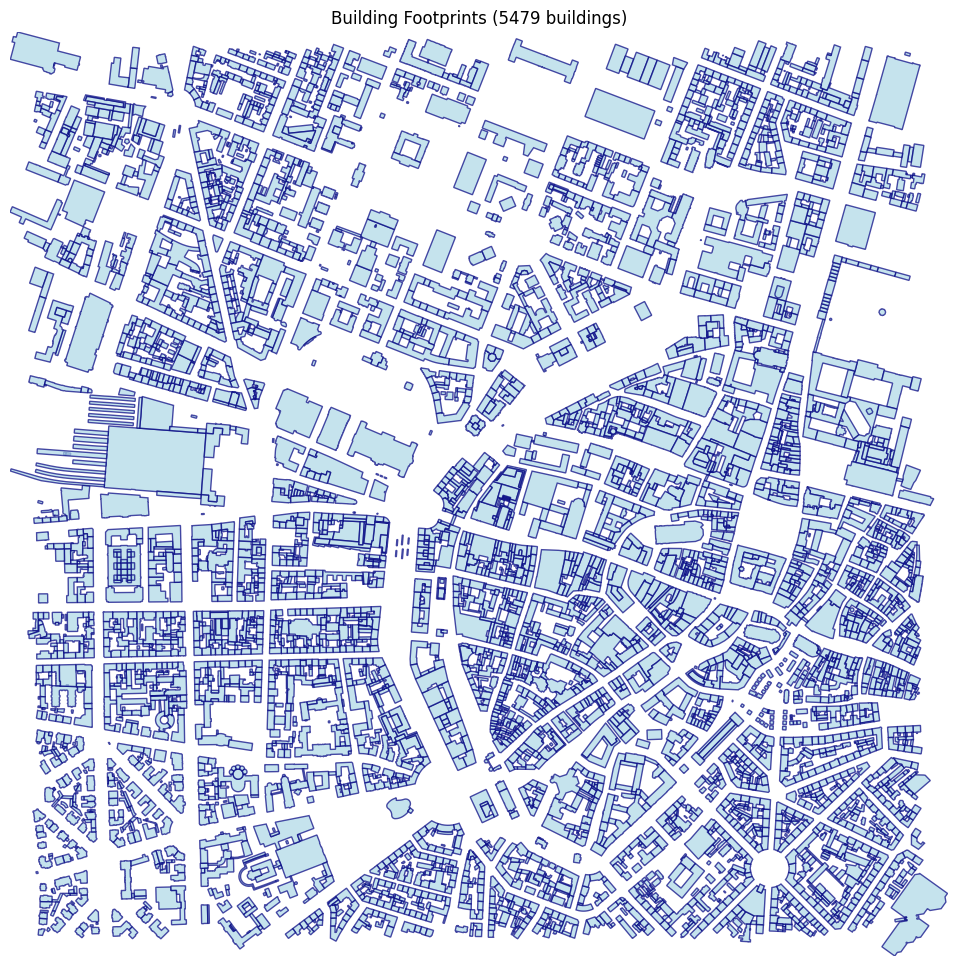

In [95]:
buildings = root.findall(".//bldg:Building",namespaces=namespace)
if buildings:
    print(f'Total Buildings Parsed {len(buildings)}')
    building_ids, footprints = get_building_footprints(buildings)
    print(f"{len(footprints)} Extracted")
    plot_building_footprints(building_ids,footprints)
    mlpplot_building_footprints(building_ids,footprints)
else:
    print("No Buildings Found!")


2. Extract Building Attributes
o Parse and list available attributes for each building (e.g., name, number of
storeys, building function, etc.).
o Present the extracted data in a readable format (CSV or printed summary).

In [ ]:
buildings_attributes = []
for building in buildings:
  building_data = {}
  if building:
    building_data['ID'] = building.get('{http://www.opengis.net/gml}id')
    name = building.find(".//externalReference/externalObject/name",namespaces=namespace)
    building_data['Name'] = name.text if name is not None else None
    location = building.find('.//gen:stringAttribute[@name="DatenquelleLage"]/gen:value',namespaces=namespace)
    building_data['Location'] = location.text if location is not None else None
    community = building.find('.//gen:stringAttribute[@name = "Gemeindeschluessel"]/gen:value',namespaces=namespace)
    building_data['Community'] = community.text if community is not None else None
    function = building.find('bldg:function',namespaces=namespace)
    building_data['Function'] = function.text if function is not None else None
    roof_type = building.find('bldg:roofType',namespaces=namespace)
    building_data['Roof Type'] = roof_type.text if roof_type is not None else None
    storeys = building.find('bldg:storeysAboveGround',namespaces=namespace)
    building_data['Storeys'] = int(storeys.text) if storeys is not None else None
    height = building.find('bldg:measuredHeight',namespaces=namespace)
    building_data['Building Height'] = float(height.text) if height is not None else None
    area = building.find('.//bldg:GroundSurface/gen:stringAttribute[@name="Flaeche"]/gen:value', namespace)
    building_data['Ground Surface Area'] =  area.text if area is not None else None
    building_coords = building.find('.//bldg:GroundSurface', namespace).find(".//gml:Polygon",namespace).find(".//gml:posList",namespace).text.strip().split()
    building_coords = [(float(i),float(i+1)) for i in range(0, len(building_coords),3)]
    building_data['centroid'] = Polygon(building_coords).centroid
    buildings_attributes.append(building_data)

headers = list(buildings_attributes[0].keys())
with open('building.csv','w') as file:
      writer = csv.DictWriter(file,fieldnames=headers)
      writer.writeheader()
      writer.writerows(buildings_attributes)

C:\Users\veena\AppData\Local\Temp\ipykernel_30272\4091417214.py:4: DeprecationWarning: Testing an element's truth value will always return True in future versions.  Use specific 'len(elem)' or 'elem is not None' test instead.
  if building:
